In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.manifold import TSNE

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


True

In [22]:
df = pd.read_csv('IMDB Dataset.csv')
df=df[:2500]
df.head(10)

df.sentiment.replace('positive',1,inplace=True)
df.sentiment.replace('negative',0,inplace=True)

#Remove HTML tags
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)

df.review = df.review.apply(clean)


In [23]:
df.shape


(2500, 2)

In [24]:
df.index = range(2500)

df['review'].apply(lambda x: len(x.split(' '))).sum()


558966

In [25]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['review'] = df['review'].apply(cleanText)

In [26]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['review']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['review']), tags=[r.sentiment]), axis=1)

In [27]:
train_tagged.values[30]


TaggedDocument(words=['saw', 'this', 'movie', 'with', 'friend', 'who', 'ran', 'marathon', 'with', 'me', 'and', 'we', 'both', 'had', 'the', 'same', 'feeling', 'about', 'it', 'it', 'was', "n't", 'terribly', 'motivating', 'and', 'did', "n't", 'even', 'broach', 'the', 'idea', 'of', 'what', 'training', 'schedule', 'would', 'look', 'like', 'so', 'that', 'non-marathoners', 'could', 'have', 'an', 'idea', 'of', 'what', 'it', 'would', 'take', 'for', 'them', 'to', 'train', 'and', 'run', 'one', 'in', 'fact', 'there', 'was', 'almost', 'zero', 'technical', 'information', 'at', 'all', 'did', "n't", 'epect', 'this', 'to', 'be', 'tech-heavy', 'instructional', 'video', 'but', 'when', 'that', 'info', 'was', 'near', 'zero', 'then', 'the', 'film', 'just', 'was', "n't", 'balanced', 'and', 'was', "n't", 'particularly', 'useful', 'to', 'non-marathoners', 'contemplating', 'their', 'first', 'run.there', 'were', 'other', 'problems', 'some', 'of', 'the', 'very', 'first', 'images', 'were', 'people', 'collapsing', 

In [28]:
import multiprocessing
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 1750/1750 [00:00<00:00, 261016.04it/s]


In [29]:
%%time
for epoch in range(3):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 1750/1750 [00:00<00:00, 470907.29it/s]


CPU times: user 4.06 s, sys: 48.1 ms, total: 4.11 s
Wall time: 2.26 s


In [30]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [31]:
trainy, trainx = vec_for_learning(model_dbow, train_tagged)
testy, testx = vec_for_learning(model_dbow, test_tagged)


In [32]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values[:50]:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

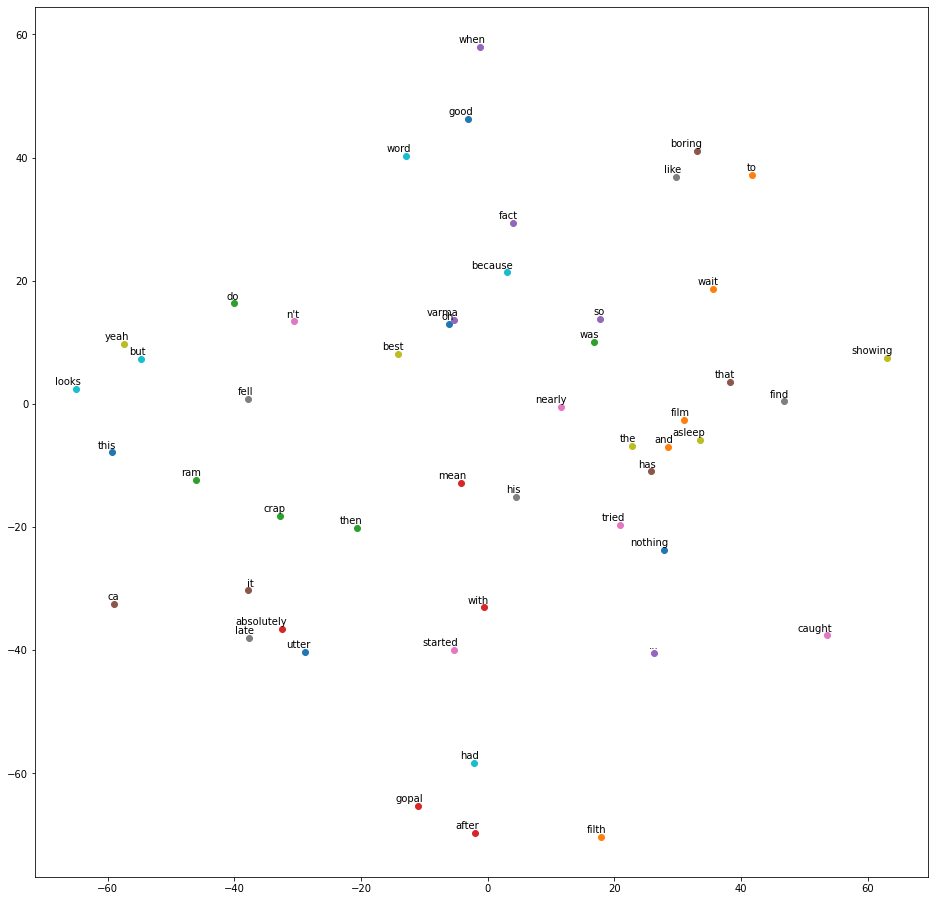

In [33]:
#plotting 50 vocab
tsne_plot(model_dbow)

In [34]:
testx[1].shape

(300,)

In [35]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


In [36]:
gnb,bnb = GaussianNB(),BernoulliNB(alpha=1.0,fit_prior=True)
tree_clf = tree.DecisionTreeClassifier()
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
svm_clf = svm.SVC()

gnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)
tree_clf.fit(trainx,trainy)
rf_clf.fit(trainx,trainy)
svm_clf.fit(trainx,trainy)

    #Prediction and accuracy metrics to choose best model
ypg = gnb.predict(testx)
ypb = bnb.predict(testx)
ypt = tree_clf.predict(testx)
ypr = rf_clf.predict(testx)
yps = svm_clf.predict(testx)
print("Gaussian = ",accuracy_score(testy,ypg))
print("Bernoulli = ",accuracy_score(testy,ypb))
print("Tree = ",accuracy_score(testy,ypt))
print("RandomForest = ",accuracy_score(testy,ypr))
print("SVM = ",accuracy_score(testy,yps))


Gaussian =  0.804
Bernoulli =  0.8
Tree =  0.76
RandomForest =  0.8093333333333333
SVM =  0.8106666666666666


In [37]:
def plot_svm(clf,df,Name):
    
  bow_pca = PCA(n_components=2)
  BowComponents = bow_pca.fit_transform(df)
  # trainx,testx,trainy,testyy = train_test_split(BowComponents,testy,test_size=0.2,random_state=9)

  svm_clf = svm.SVC()

  svm_pca=clf.fit(BowComponents,testy)

  h = .02 
  x_min, x_max = BowComponents[:, 0].min() - 1, BowComponents[:, 0].max() + 1
  y_min, y_max = BowComponents[:, 1].min() - 1, BowComponents[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  titles = f"2{Name} component PCA"
  plt.subplot()
  Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
  plt.scatter(BowComponents[:, 0], BowComponents[:, 1], c=testy, cmap=plt.cm.coolwarm)
  plt.xlabel('PCA component 0')
  plt.ylabel('PCA component 1')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.xticks(())
  plt.yticks(())
  plt.title(titles)

  plt.show()

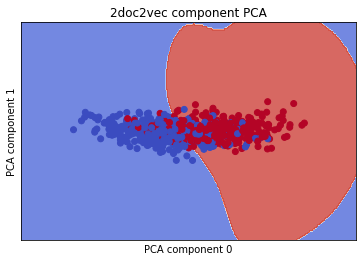

In [38]:
from sklearn.decomposition import PCA

plot_svm(svm_clf,testx,"doc2vec")


In [39]:

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
def clustering(X,y,Name):
    
    modelkmeans = KMeans(n_clusters=2)
    modelkmeans.fit(X)
    kmeanspred = modelkmeans.fit_predict(X)
    c=0
    for i in range(len(y)):
        if y[i]==kmeanspred[i]:
            c+=1
    print("Kmeans = ",max(c/len(y),1-c/len(y))*100)

    aclustering = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
    aclusteringpred = aclustering.fit_predict(X)
    c=0
    for i in range(len(y)):
        if y[i]==aclusteringpred[i]:
            c+=1
    print("AClustering = ",max(c/len(y),1-c/len(y))*100)
    return modelkmeans,aclustering


In [40]:
doc_kmeans,doc_aclus=clustering(trainx,trainy,"Doc2vec")

Kmeans =  89.08571428571429
AClustering =  84.22857142857143


In [59]:
predictions = doc_aclus.fit_predict(testx)
accuracy_score(testy,predictions)

0.292

#The accuracy of AgglomerativeClustering is (1-0.292 = 70.8), because of the interchanged clusters

In [54]:
predictions = doc_kmeans.predict(testx)
accuracy_score(testy,predictions)

0.8026666666666666

In [41]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
trainy=labelencoder_y.fit_transform(trainy)
      

In [42]:
def kmeans_plot(kmeans_modelg,df,featurename):
  bow_pca = PCA(n_components=2)
  BowComponents = bow_pca.fit_transform(df)
  BowDf = pd.DataFrame(data = BowComponents, columns = [f"{featurename} component 1",f"{featurename} component 2"])
  bow_centers = bow_pca.transform(kmeans_modelg.cluster_centers_)

  n = BowComponents.shape[0]
  centers_old = np.zeros(bow_centers.shape) # to store old centers
  centers_new = deepcopy(bow_centers)

  clusters = np.zeros(n)
  distances = np.zeros((n,2))

  error = np.linalg.norm(centers_new - centers_old)

  while error != 0:
      # Measure the distance to every center
      for i in range(2):
          distances[:,i] = np.linalg.norm(BowComponents - bow_centers[i], axis=1)
      # Assign all training data to closest center
      clusters = np.argmin(distances, axis = 1)
      centers_old = deepcopy(centers_new)
      # Calculate mean for every cluster and update the center
      for i in range(2):
          centers_new[i] = np.mean(BowComponents[clusters == i], axis=0)
      error = np.linalg.norm(centers_new - centers_old)
  centers_new 
  centers_new = centers_new

  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1)
  ax.set_xlabel(f'{featurename} Component 1', fontsize = 10)
  ax.set_ylabel(f'{featurename} Component 2', fontsize = 10)
  ax.set_title(f"2{featurename} component PCA", fontsize = 15)

  colors = ['y', 'r']  
  for color, i, target_name in zip(colors, [0, 1], ["Negative","Postive"]):
      ax.scatter(BowComponents[trainy == i, 0], BowComponents[trainy == i, 1], alpha=.8, color=color,
                  label=target_name, s = 10)
  ax.legend(loc='best', shadow=False, scatterpoints=1)
  ax.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='k', label = 'centroid', s=150)
  ax.grid()





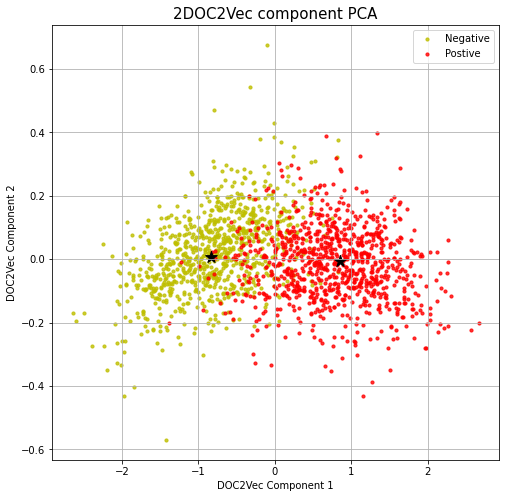

In [43]:
kmeans_plot(doc_kmeans,trainx,"DOC2Vec")

In [44]:
 
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score
kappa_tf_kmeans=cohen_kappa_score(doc_kmeans.predict(trainx), trainy)
kappa_agg_tf=cohen_kappa_score(doc_aclus.fit_predict(trainx), trainy)
silhouette_bow_kmeans = (silhouette_score(trainx, doc_kmeans.predict(trainx), metric='euclidean'))
silhouette_agg_bow = (silhouette_score(trainx, doc_aclus.fit_predict(trainx), metric='euclidean'))

In [45]:
print(kappa_agg_tf)
print(kappa_tf_kmeans)
print(silhouette_bow_kmeans)
print(silhouette_agg_bow)

0.6862238633573137
0.7817502033950984
0.5783384
0.548675


In [56]:
def test(rev):
    f1 = clean(rev)
    f2 = cleanText(f1)
    f3 = tokenize_text(f2)
    f4_d2v = model_dbow.infer_vector(f3, steps=20)
    kmeanspred = doc_kmeans.predict([f4_d2v])
    return kmeanspred[0]

In [60]:
test("not bad")

1

In [48]:
import pickle
with open(r'mrkmeans.pkl','wb') as model_pkl:
    pickle.dump(doc_kmeans, model_pkl, protocol=2)